# PNAS dataset exploration
This notebook contain preprocessing and exploration of the pnas article dataset.

The goal is to get the non homology protein and use it for training and fine tunning.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
# retina display
%config InlineBackend.figure_format='retina'

/home/shaharax/.conda/envs/esm2_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mega_train_path = '../data/Processed_K50_dG_datasets/Pnas_filtering/mega_train.csv'
mega_val_path = '../data/Processed_K50_dG_datasets/Pnas_filtering/mega_val.csv'

mega_train = pd.read_csv(mega_train_path)
mega_val = pd.read_csv(mega_val_path)
display(mega_train.head())
display(mega_val.head())

,Unnamed: 0,name,ddG_ML,mut_type,WT_name,aa_seq,wt_seq
0,0,r10_437_TrROS_Hall.pdb,0.016723,wt,r10_437_TrROS_Hall.pdb,EPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP,EPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP
1,1,r10_437_TrROS_Hall.pdb_wty,0.090124,wt,r10_437_TrROS_Hall.pdb,EPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP,EPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP
2,2,r10_437_TrROS_Hall.pdb_wte,0.000000,wt,r10_437_TrROS_Hall.pdb,EPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP,EPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP
3,3,r10_437_TrROS_Hall.pdb_wtm,-0.005570,wt,r10_437_TrROS_Hall.pdb,EPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP,EPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP
4,4,r10_437_TrROS_Hall.pdb_wth,-0.046900,wt,r10_437_TrROS_Hall.pdb,EPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP,EPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP


,Unnamed: 0,name,dna_seq,log10_K50_t,log10_K50_t_95CI_high,log10_K50_t_95CI_low,log10_K50_t_95CI,fitting_error_t,log10_K50unfolded_t,deltaG_t,...,WT_cluster,log10_K50_trypsin_ML,log10_K50_chymotrypsin_ML,dG_ML,ddG_ML,Stabilizing_mut,match_aaseq,name_original,pair_name,wt_seq
0,34875,r15_550_TrROS_Hall.pdb,TCTGCTGGTGGTTCTGCGGAGGTTTACAAAGTTAAAATCAAAATCG...,1.787626,1.861168,1.710206,0.150961,0.090025,-1.229404,4.153717,...,hall,1.7876261836483618,1.2918416317116157,4.491454,0.000000,False,Ture,r15_550_TrROS_Hall.pdb,NaN,EVYKVKIKIERVLPNGEKVEEEITIEVEGMSEEELLALARELAAEP...
1,34876,r15_550_TrROS_Hall.pdb_wtm,TCCGCGGGTGGCTCTGCGGAAGTTTACAAGGTTAAGATCAAAATCG...,1.740448,1.785976,1.696999,0.088977,0.097088,-1.229404,4.076458,...,hall,1.7404481978688096,1.3394145270879494,4.534477,0.043023,False,Ture,r15_550_TrROS_Hall.pdb_wtm,NaN,EVYKVKIKIERVLPNGEKVEEEITIEVEGMSEEELLALARELAAEP...
2,34877,r15_550_TrROS_Hall.pdb_wte,TCTGCGGGTGGTTCTGCGGAGGTTTACAAAGTTAAGATCAAAATCG...,1.627827,1.709146,1.564937,0.144209,0.127220,-1.229404,3.898618,...,hall,1.6278270916729247,1.212086175692947,4.319446,-0.172007,False,Ture,r15_550_TrROS_Hall.pdb_wte,NaN,EVYKVKIKIERVLPNGEKVEEEITIEVEGMSEEELLALARELAAEP...
3,34878,r15_550_TrROS_Hall.pdb_wth,TCTGCTGGCGGTTCTGCGGAAGTTTACAAAGTTAAAATCAAGATCG...,1.920790,1.974979,1.835599,0.139380,0.121952,-1.229404,4.384066,...,hall,1.920789828822124,1.246577328815766,4.501479,0.010025,-,Ture,r15_550_TrROS_Hall.pdb_wth,NaN,EVYKVKIKIERVLPNGEKVEEEITIEVEGMSEEELLALARELAAEP...
4,34879,r15_550_TrROS_Hall.pdb_wty,TCCGCTGGTGGCTCTGCGGAAGTTTACAAAGTTAAGATCAAGATCG...,1.697426,1.758440,1.641514,0.116926,0.111812,-1.229404,4.007530,...,hall,1.697426071545729,1.3020644609860044,4.480774,-0.010679,False,Ture,r15_550_TrROS_Hall.pdb_wty,NaN,EVYKVKIKIERVLPNGEKVEEEITIEVEGMSEEELLALARELAAEP...


In [3]:
# Add protein name column
mega_train['protein_name'] = mega_train['name'].apply(lambda x: x.split('.')[0])
mega_val['protein_name'] = mega_val['name'].apply(lambda x: x.split('.')[0])
# print number of unique proteins
print('Number of unique proteins in train set:', mega_train['protein_name'].nunique())
print('Number of unique proteins in val set:', mega_val['protein_name'].nunique())
# overlap between train and val proteins
train_proteins = set(mega_train['protein_name'].unique())
val_proteins = set(mega_val['protein_name'].unique())
overlap = train_proteins.intersection(val_proteins)
print('Number of proteins in train set:', len(train_proteins))

Number of unique proteins in train set: 239
Number of unique proteins in val set: 31
Number of proteins in train set: 239


We can see there are overlap in the protein with training and validation, the diffrence is in the mutation.

In [4]:
# Save the proteins in the train set and val set to a file
train_proteins = pd.DataFrame(list(train_proteins), columns=['protein_name'])

train_proteins.to_csv('../data/Processed_K50_dG_datasets/Pnas_filtering/train_proteins.csv', index=False)
all_mutations = pd.concat([mega_train, mega_val])
all_mutations.to_csv('../data/Processed_K50_dG_datasets/Pnas_filtering/pnas_mutations.csv', index=False)

In [5]:
train_proteins

,protein_name
0,1PWT
1,r11_829_TrROS_Hall
2,EHEE_rd4_0864
3,4HCK
4,2LHC
...,...
234,1TG0
235,1GL5
236,EEHEE_rd4_0763
237,2KVT


In [6]:
# Check the diffrence between name and name original
mega_val[mega_val['name_original'] != mega_val['name']]

,Unnamed: 0,name,dna_seq,log10_K50_t,log10_K50_t_95CI_high,log10_K50_t_95CI_low,log10_K50_t_95CI,fitting_error_t,log10_K50unfolded_t,deltaG_t,...,log10_K50_trypsin_ML,log10_K50_chymotrypsin_ML,dG_ML,ddG_ML,Stabilizing_mut,match_aaseq,name_original,pair_name,wt_seq,protein_name


In [7]:
# get all indexes if name is not in the mega_val
mega_val[~mega_val['name'].isin(mega_train['protein_name'])].index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            27471, 27472, 27473, 27474, 27475, 27476, 27477, 27478, 27479,
            27480],
           dtype='int64', length=27481)

In [8]:
mega_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216919 entries, 0 to 216918
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    216919 non-null  int64  
 1   name          216919 non-null  object 
 2   ddG_ML        216919 non-null  float64
 3   mut_type      216919 non-null  object 
 4   WT_name       216919 non-null  object 
 5   aa_seq        216919 non-null  object 
 6   wt_seq        216919 non-null  object 
 7   protein_name  216919 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 13.2+ MB


In [9]:
# Check proteins that are in the test and in the train
TM_PATH = "../data/ThermoMPNN/mega_test.csv"
mega_test = pd.read_csv(TM_PATH)
mega_test['protein_name'] = mega_test['name'].apply(lambda x: x.split('.')[0])
mega_test

,Unnamed: 0,name,dna_seq,log10_K50_t,log10_K50_t_95CI_high,log10_K50_t_95CI_low,log10_K50_t_95CI,fitting_error_t,log10_K50unfolded_t,deltaG_t,...,log10_K50_trypsin_ML,log10_K50_chymotrypsin_ML,dG_ML,ddG_ML,Stabilizing_mut,match_aaseq,name_original,pair_name,wt_seq,protein_name
0,93288,3DKM.pdb,TCCGCTGGTGGCAACCTCTACTTCCAGGGTCTGAAATACATGGTGC...,0.873456,0.893782,0.826958,0.066824,0.053434,-1.456179,3.122373,...,0.8734555920487248,-0.3392881061023177,3.115544,0.646712,-,Ture,3DKM.pdb,NaN,NLYFQGLKYMVPGARVTRGLDWKWRDQDGSPQGEGTVTGELHNGWI...,3DKM
1,93289,3DKM.pdb_wte,AACCTGTACTTCCAGGGTCTGAAATACATGGTTCCAGGTGCGCGCG...,0.377778,0.391423,0.361034,0.030389,0.034944,-1.452214,2.439704,...,0.3777782777789136,-0.8902230423412945,2.458238,-0.010594,False,Ture,3DKM.pdb_wte,NaN,NLYFQGLKYMVPGARVTRGLDWKWRDQDGSPQGEGTVTGELHNGWI...,3DKM
2,93290,3DKM.pdb_wth,AACCTGTACTTCCAGGGTCTGAAATACATGGTGCCGGGTGCTCGTG...,0.365208,0.408840,0.324263,0.084577,0.045616,-1.452214,2.422535,...,0.3652084245513086,-0.8874495769500115,2.449336,-0.019497,False,Ture,3DKM.pdb_wth,NaN,NLYFQGLKYMVPGARVTRGLDWKWRDQDGSPQGEGTVTGELHNGWI...,3DKM
3,93291,3DKM.pdb_wty,AACCTGTACTTCCAGGGTCTGAAATACATGGTTCCAGGTGCGCGTG...,0.422846,0.442967,0.400679,0.042288,0.035603,-1.452214,2.501233,...,0.4228463966098814,-0.9035919050650832,2.461207,-0.007625,False,Ture,3DKM.pdb_wty,NaN,NLYFQGLKYMVPGARVTRGLDWKWRDQDGSPQGEGTVTGELHNGWI...,3DKM
4,93292,3DKM.pdb_wtm,AACCTGTACTTCCAGGGTCTGAAATACATGGTTCCAGGTGCGCGTG...,0.393485,0.405955,0.370929,0.035026,0.041219,-1.452214,2.461152,...,0.3934852856592937,-0.8432640023055895,2.476458,0.007625,False,Ture,3DKM.pdb_wtm,NaN,NLYFQGLKYMVPGARVTRGLDWKWRDQDGSPQGEGTVTGELHNGWI...,3DKM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28307,182026,6EWU.pdb_D56W,TCTGCTGGCGGCTCCGCGGGTGGTATCGACGCTGCGCAAATCGTTG...,1.528508,1.638270,1.410658,0.227612,0.140693,-0.947401,3.370130,...,1.528507614444325,-0.0847987838117073,3.406731,-0.201824,-,Ture,6EWU.pdb_D56W,NaN,IDAAQIVDEALEQGITLFVVNNRLQYETSRDSIPTELLNKWKQHKQ...,6EWU
28308,182027,6EWU.pdb_D56Y,TCTGCTGGCGGTTCTGCGGGTGGTATCGACGCTGCTCAGATCGTTG...,1.575215,1.675937,1.441578,0.234359,0.163195,-0.902330,3.380250,...,1.5752152421533807,0.3986275314086588,3.737504,0.128949,-,Ture,6EWU.pdb_D56Y,NaN,IDAAQIVDEALEQGITLFVVNNRLQYETSRDSIPTELLNKWKQHKQ...,6EWU
28309,182028,6EWU.pdb_D56F,TCTGCGGGCGGTTCTGCTGGCGGCATCGACGCGGCTCAGATCGTTG...,1.674407,1.754449,1.549398,0.205051,0.098218,-0.921843,3.559684,...,1.674407051936401,0.2044362241068694,3.684329,0.075774,-,Ture,6EWU.pdb_D56F,NaN,IDAAQIVDEALEQGITLFVVNNRLQYETSRDSIPTELLNKWKQHKQ...,6EWU
28310,182029,6EWU.pdb_D56P,TCTGCTGGTGGCTCTGCGGGCGGTATCGACGCGGCTCAGATCGTTG...,1.823671,1.969976,1.764981,0.204995,0.144382,-0.786574,3.621791,...,1.823670898161496,0.4987647241591906,3.805480,0.196925,-,Ture,6EWU.pdb_D56P,NaN,IDAAQIVDEALEQGITLFVVNNRLQYETSRDSIPTELLNKWKQHKQ...,6EWU


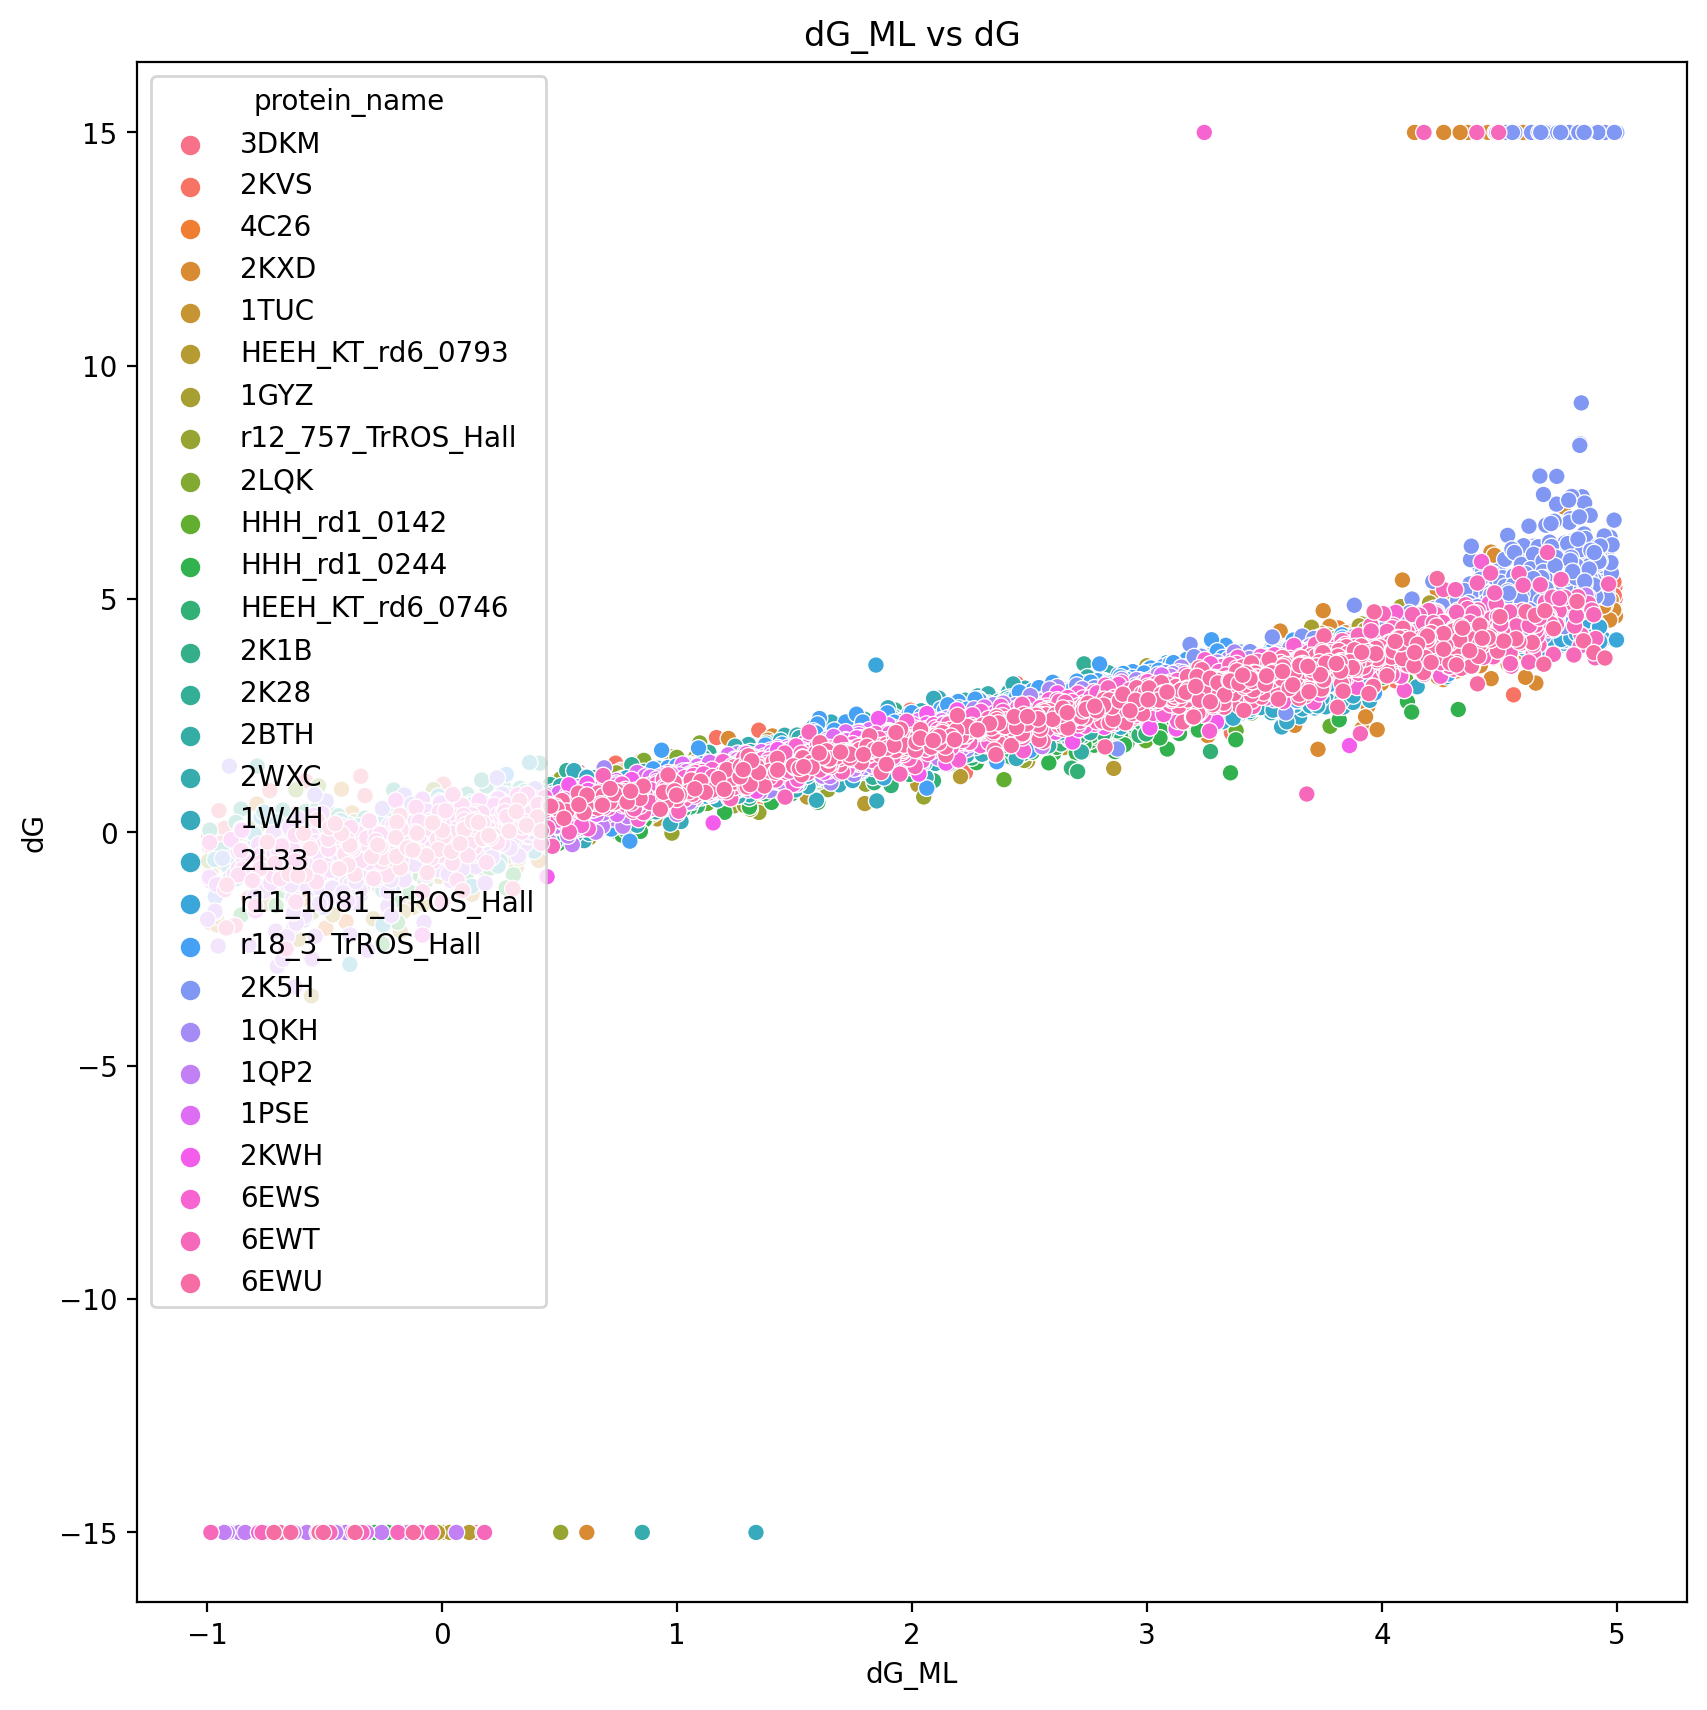

In [10]:
# DG ML vs DG
plt.figure(figsize=(10, 10))
sns.scatterplot(data=mega_test, x='dG_ML', y='deltaG_t', hue='protein_name')
plt.xlabel('dG_ML')
plt.ylabel('dG')
plt.title('dG_ML vs dG')
plt.show()

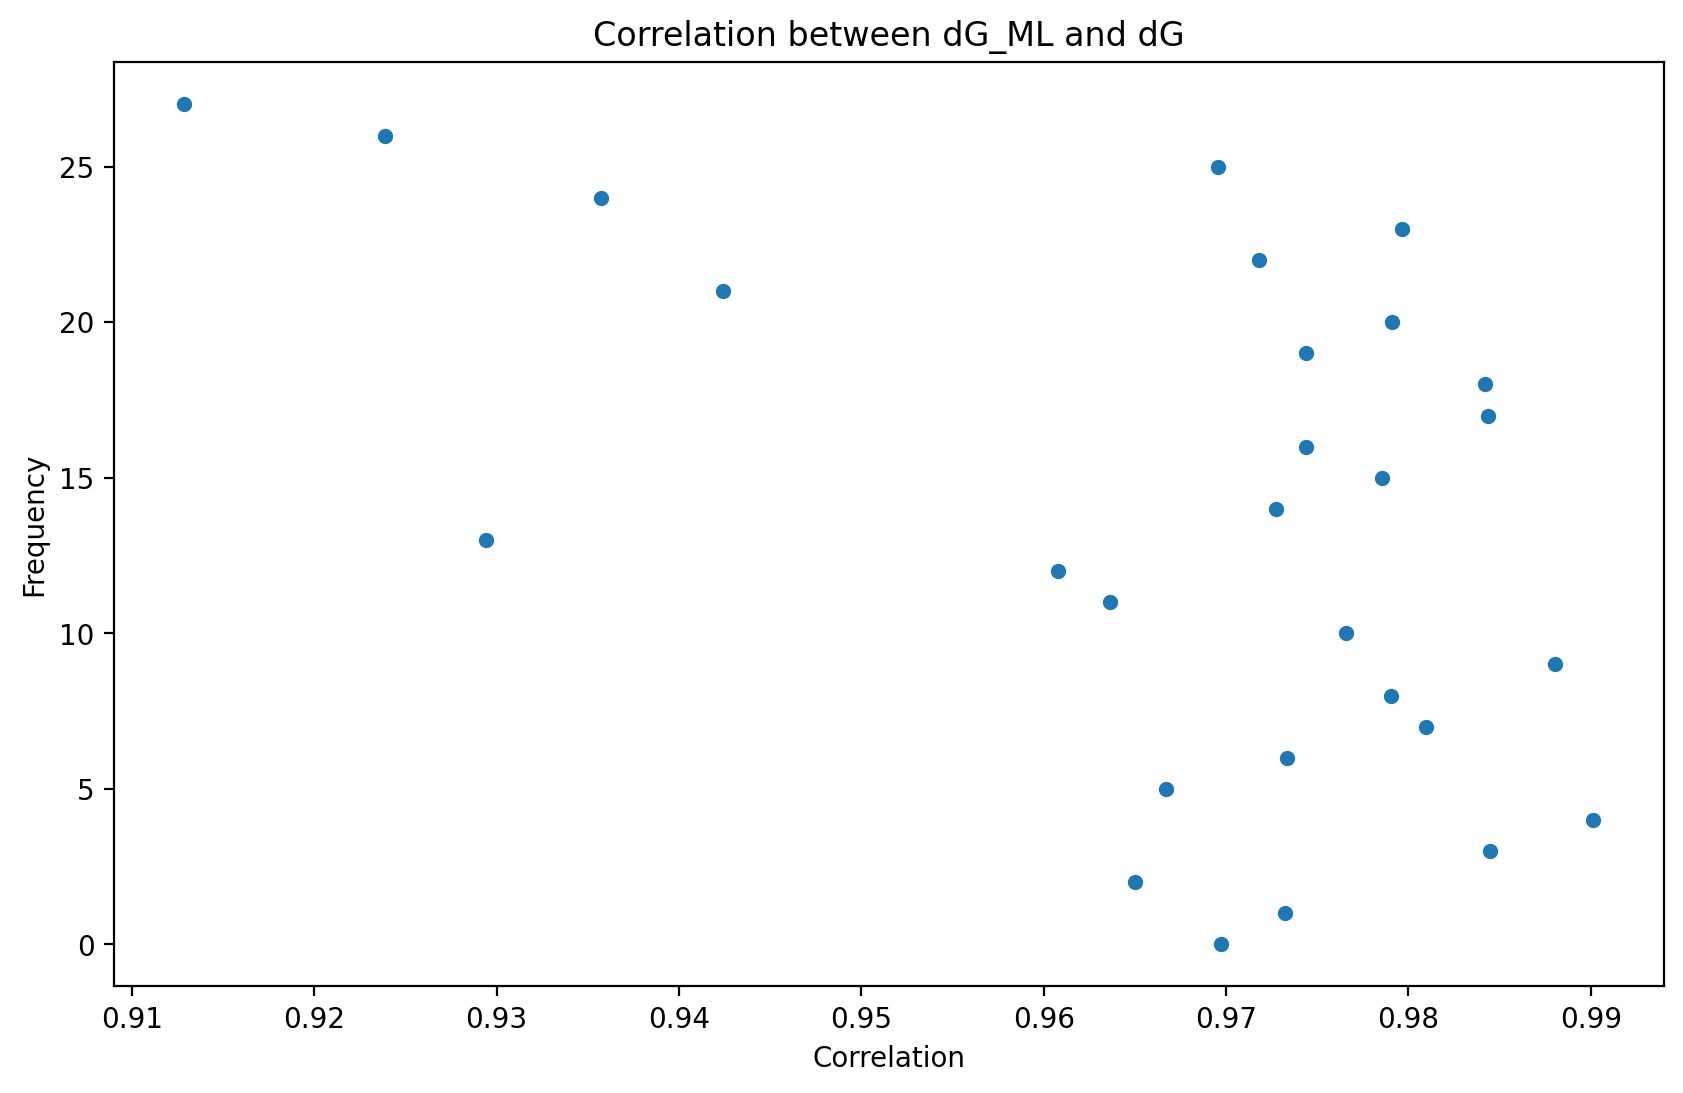

In [11]:
# Plot correlation between dG_ML and dG
prot_df = mega_test.groupby('protein_name')
corrs_1_5 = []
for name, group in prot_df:
    group = group[(group['deltaG_t']<4) & (group['deltaG_t']>0)]
    corr = group['dG_ML'].corr(group['deltaG_t'])
    corrs_1_5.append(corr)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=corrs_1_5, y=range(len(corrs_1_5)))
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.title('Correlation between dG_ML and dG')
plt.show()

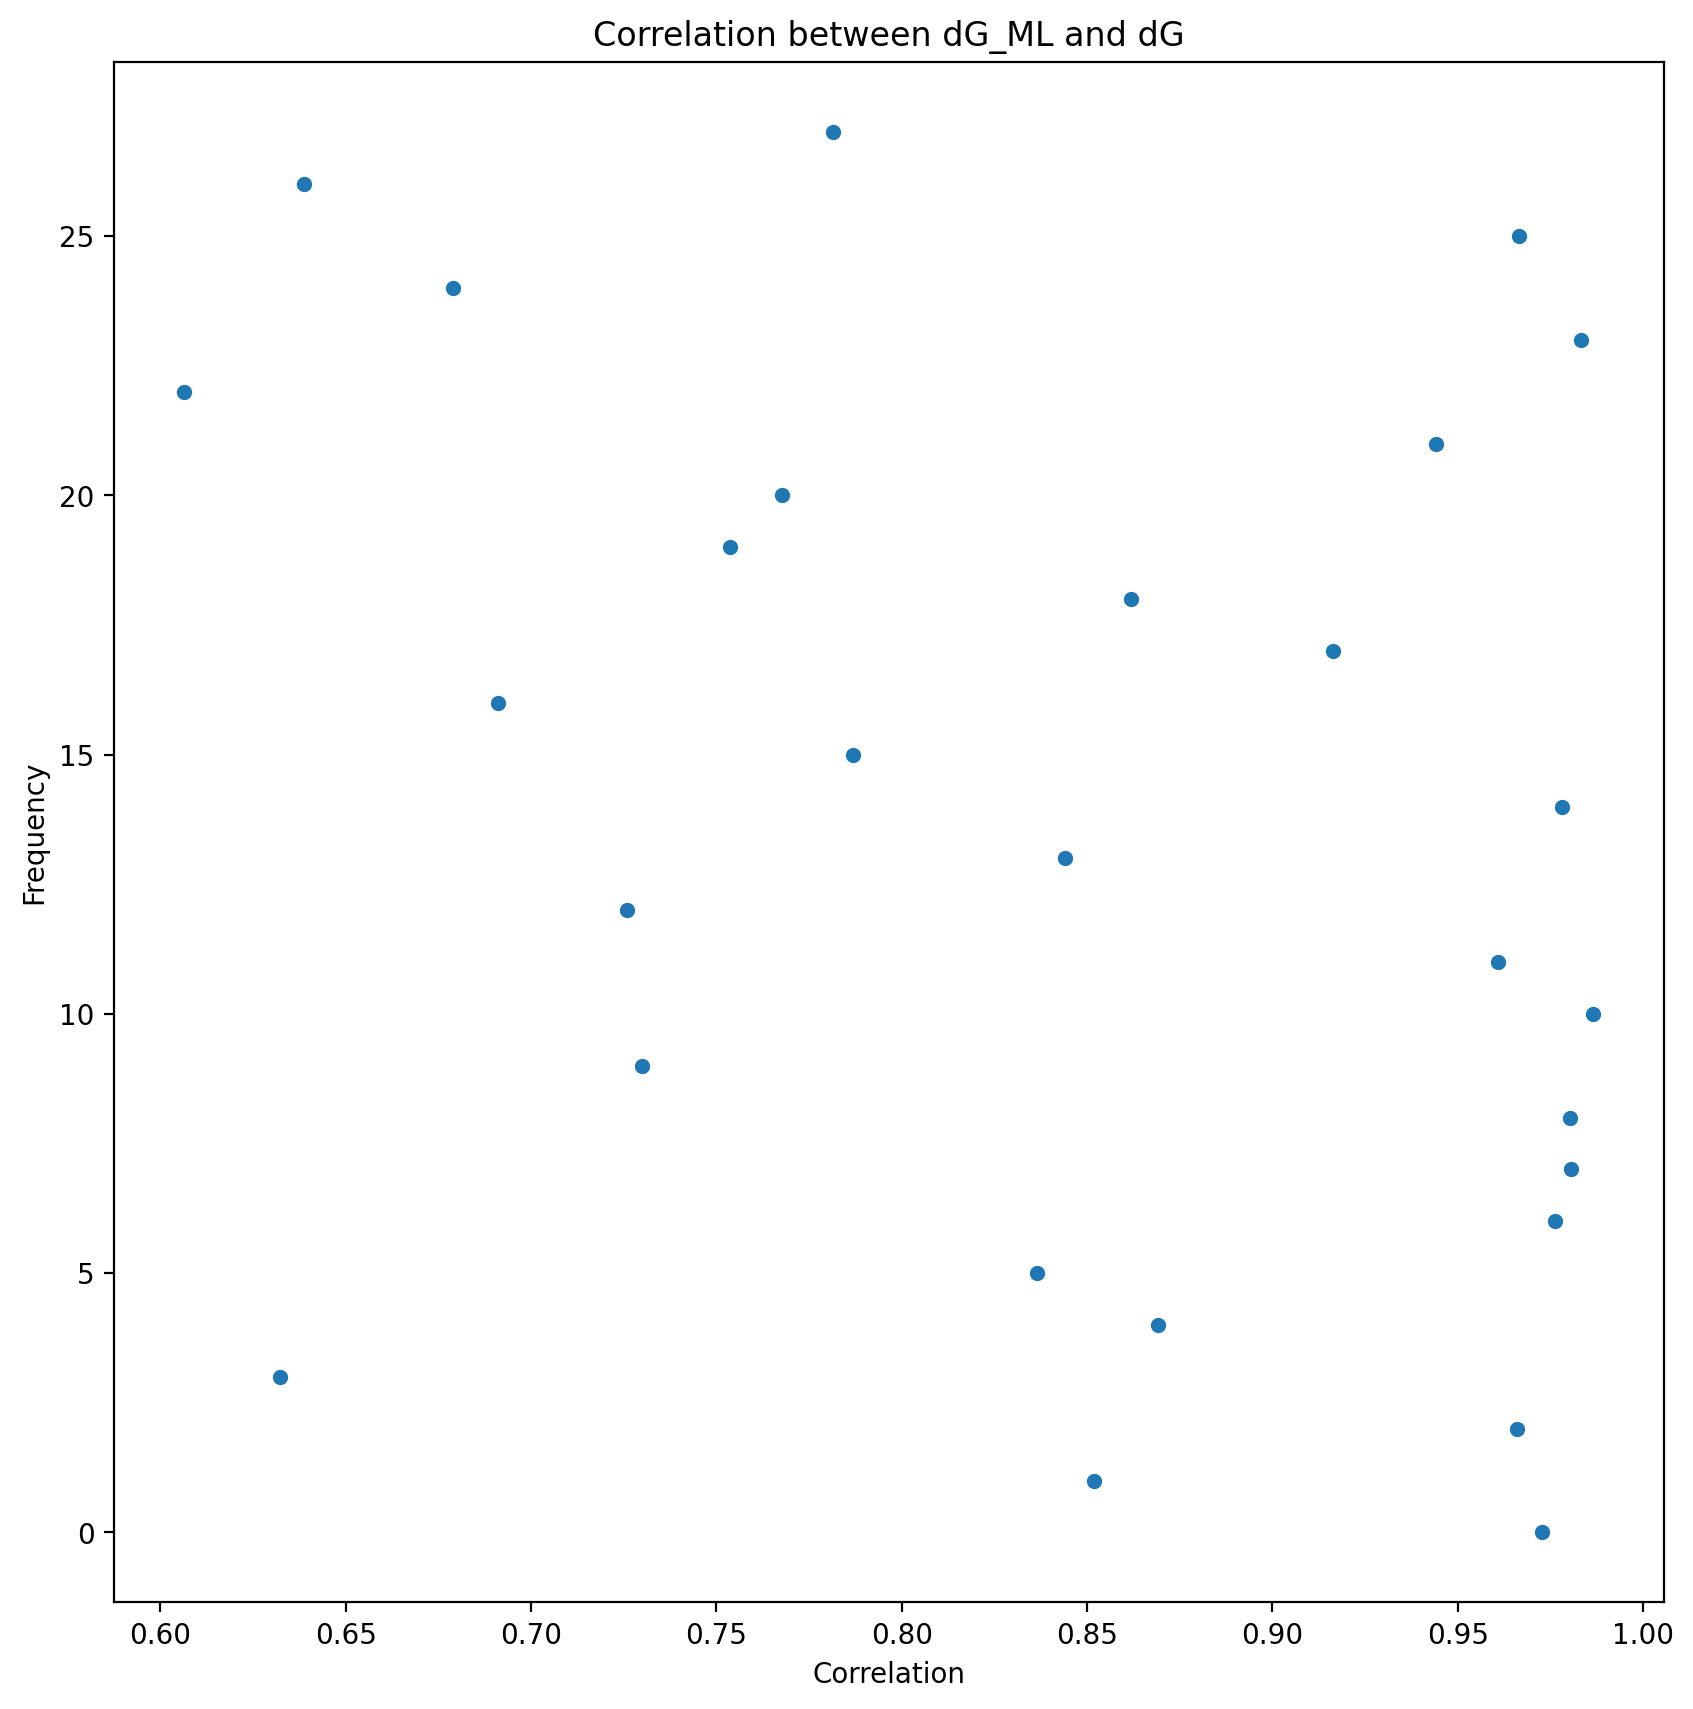

In [12]:
# Plot correlation between dG_ML and dG
prot_df = mega_test.groupby('protein_name')
corrs = []
for name, group in prot_df:
    corr = group['dG_ML'].corr(group['deltaG_t'])
    corrs.append(corr)
plt.figure(figsize=(10, 10))
sns.scatterplot(x=corrs, y=range(len(corrs)))
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.title('Correlation between dG_ML and dG')
plt.show()

In [16]:
# Check how many proteins are in the test set and in the train set
train_proteins = set(mega_train['protein_name'].unique())
val_proteins = set(mega_val['protein_name'].unique())
test_proteins = set(mega_test['protein_name'].unique())
overlap = train_proteins.intersection(test_proteins)
overlap_val = val_proteins.intersection(train_proteins)
print('Number of proteins in train set:', len(train_proteins))
print('Number of proteins in test set:', len(test_proteins))
print('Number of proteins in common:', len(overlap))

print('Number of proteins in val set:', len(val_proteins))
print('Number of proteins in common:', len(overlap_val))

Number of proteins in train set: 239
Number of proteins in test set: 28
Number of proteins in common: 0
Number of proteins in val set: 31
Number of proteins in common: 0


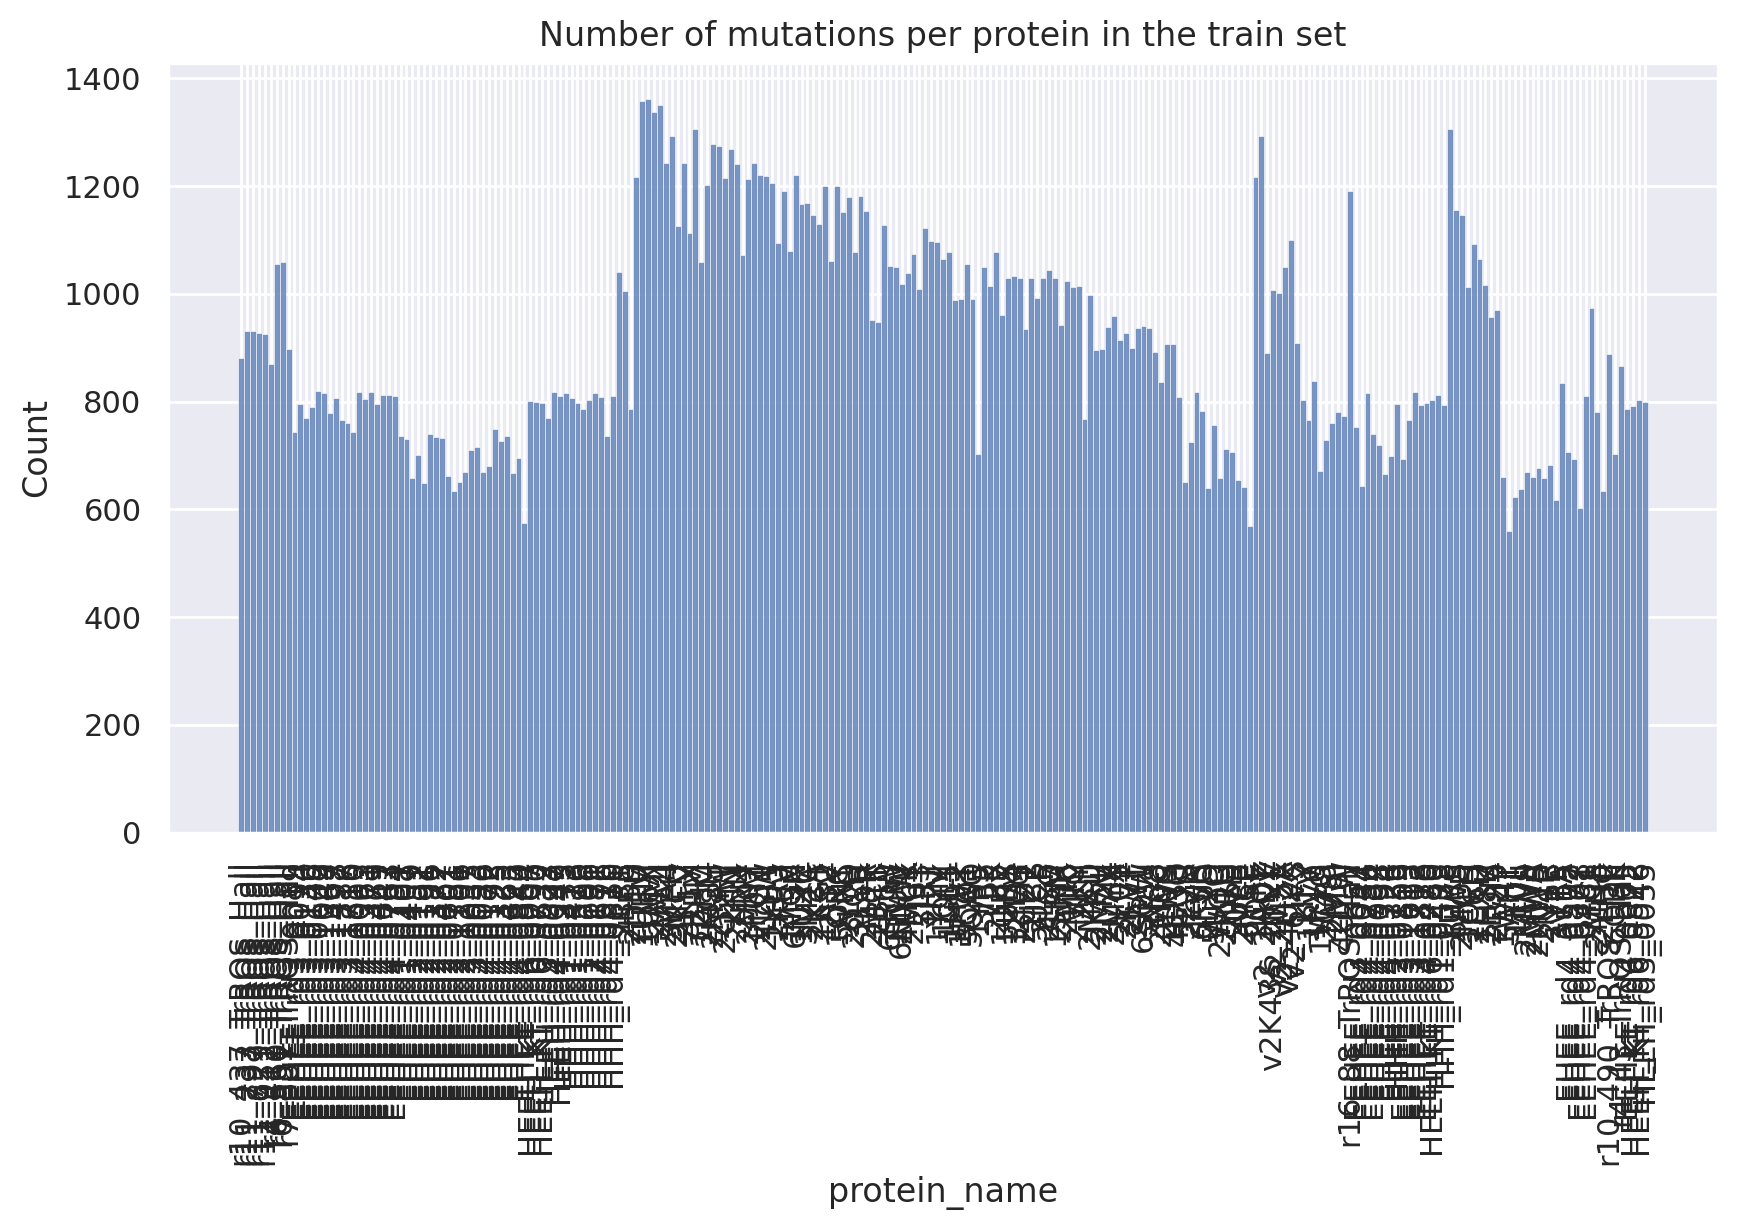

In [17]:
# Plot mutations per protein
sns.set_theme()
plt.figure(figsize=(10, 5))
sns.histplot(mega_train['protein_name'], bins=100)
plt.xticks(rotation=90)
plt.title('Number of mutations per protein in the train set')
plt.show()

In [18]:
len(mega_train)

216919

In [ ]:
mega_test['deltaG_t']

0        3.122373
1        2.439704
2        2.422535
3        2.501233
4        2.461152
           ...   
28307    3.370130
28308    3.380250
28309    3.559684
28310    3.621791
28311    3.163341
Name: deltaG_t, Length: 28312, dtype: float64

In [19]:
# Change threshold of deltaG
mega_test['deltaG_t'] = mega_test['deltaG_t'].apply(lambda x: -1 if x < -1 else 5 if x >5 else x)
print(f"max mega test: {max(mega_test['deltaG_t'])}")
print(f"min mega test: {min(mega_test['deltaG_t'])}")

max mega test: 5.0
min mega test: -1.0


# Pytorch dataset 
Check the diffrence between the 2 datasets of the training pnas and training

## Pnas ds

In [19]:
from torch.utils.data import Dataset, DataLoader
import torch
import os
import glob
import pandas as pd
import numpy as np

# Constants
# Constants
COORDS = 'coords_tensor.pt'
DELTA_G = 'deltaG.pt'
MASKS = 'mask_tensor.pt'
ONE_HOT = 'one_hot_encodings.pt'
PROTT5_EMBEDDINGS = 'prott5_embeddings'
ONE_MUT = True
UNSTABLE_MUT = False
DS_TYPE = 'pnas'
DEBUG = False
TM_PATH = "../data/ThermoMPNN/mega_test.csv"
PNAS_MUT = '../data/Processed_K50_dG_datasets/Pnas_filtering/pnas_mutations.csv'
PNAS_PROTEINS = '../data/Processed_K50_dG_datasets/Pnas_filtering/train_proteins.csv'

class PNAS_DS(Dataset):

    def __init__(self, tensor_root_dir, mutations_root_dir, train  = True, one_mut = ONE_MUT ):
        self.tensor_root_dir = tensor_root_dir
        self.train = train
        self.mutations_root_dir = mutations_root_dir
        self.protein_dirs = [protein for i, protein in enumerate(os.listdir(self.tensor_root_dir))]
        self.one_mut = one_mut # remove the mutations with more than one mutation
        self.unstable_mut = UNSTABLE_MUT
        self.ds_type = DS_TYPE
        # remove TM proteins 
        tm_proteins = pd.read_csv(TM_PATH)
        tm_proteins = tm_proteins['name'].apply(lambda x: x.split(".")[0]).unique().tolist()
        self.test_protein = [protein for protein in self.protein_dirs if protein in tm_proteins]
        self.protein_dirs = [protein for protein in self.protein_dirs if protein not in tm_proteins]
        self.pnas_mutations = pd.read_csv(PNAS_MUT)
        self.test_mutations = pd.read_csv(TM_PATH)
        # Remove the homologs from the training set
        self.remove_homologs()
        
        if DEBUG:
            self.protein_dirs = self.protein_dirs[:5]
        


    def remove_homologs(self):
        """Remove the homologs from the training set"""
        pnas_proteins = pd.read_csv(PNAS_PROTEINS)['protein_name'].tolist()
        self.protein_dirs = [protein for protein in self.protein_dirs if protein in pnas_proteins]
        
        
    def __len__(self):
        if self.train:
            return len(self.protein_dirs)
        else:
            return len(self.test_protein)

    def __getitem__(self, idx):
        if self.train:
            return self.load_protein_data(idx)
        else:
            return self.load_test_protein_data(idx)
        
    def load_test_protein_data(self, idx):
        protein_dir = os.path.join(self.tensor_root_dir, self.test_protein[idx])
        mutations_path = os.path.join(self.mutations_root_dir, f'{self.test_protein[idx]}.csv')
        mutations = pd.read_csv(mutations_path)
        mutations = mutations[~mutations['mut_type'].str.contains('ins|del')].reset_index(drop=True)
        # Load and preprocess the data for each protein
        coords_tensor = torch.load(os.path.join(protein_dir, COORDS),weights_only=True)
        delta_g_tensor = torch.load(os.path.join(protein_dir, DELTA_G),weights_only=True)
        mask_tensor = torch.load(os.path.join(protein_dir, MASKS),weights_only=True)
        one_hot_tensor = torch.load(os.path.join(protein_dir, ONE_HOT),weights_only=True)
        embedding_tensor = self.load_embedding_tensor(os.path.join(protein_dir, PROTT5_EMBEDDINGS))
        
        indexes = set(mutations.index)
        # remove unstable mut
        if not self.unstable_mut:
            indexes -= set(mutations[mutations['ddG_ML'] == '-'].index)
                 
        # remove the mutations with more than one mutation
        if self.one_mut:
            indexes -= set(mutations[mutations['mut_type'].str.contains(':')].index)
        
        if self.ds_type in ('pnas','deepef1') :
            # get the pnas mutations indexes
            indexes -= set(mutations[~mutations['name'].isin(self.test_mutations['name'])].index)
        
        indexes = list(indexes)
        mutations = mutations.loc[indexes]
        delta_g_tensor = delta_g_tensor[indexes]
        one_hot_tensor = one_hot_tensor[indexes]
        embedding_tensor = embedding_tensor[indexes]
        
        mutations_data = {
            'name': self.test_protein[idx],
            'mutations': mutations['mut_type'].to_list(),
            'prott5': embedding_tensor,
            'coords': coords_tensor,
            'one_hot': one_hot_tensor,
            'delta_g': delta_g_tensor,
            'masks': mask_tensor
        }
        
        return mutations_data
    
    def load_protein_data(self, idx):
        
        protein_dir = os.path.join(self.tensor_root_dir, self.protein_dirs[idx])
        mutations_path = os.path.join(self.mutations_root_dir, f'{self.protein_dirs[idx]}.csv')
        mutations = pd.read_csv(mutations_path)
        mutations = mutations[~mutations['mut_type'].str.contains('ins|del')].reset_index(drop=True)
        # Load and preprocess the data for each protein
        coords_tensor = torch.load(os.path.join(protein_dir, COORDS),weights_only=True)
        delta_g_tensor = torch.load(os.path.join(protein_dir, DELTA_G),weights_only=True)
        mask_tensor = torch.load(os.path.join(protein_dir, MASKS),weights_only=True)
        one_hot_tensor = torch.load(os.path.join(protein_dir, ONE_HOT),weights_only=True)
        embedding_tensor = self.load_embedding_tensor(os.path.join(protein_dir, PROTT5_EMBEDDINGS))
        
        indexes = set(mutations.index)
        # remove unstable mut
        if not self.unstable_mut:
            indexes -= set(mutations[mutations['ddG_ML'] == '-'].index)
                 
        # remove the mutations with more than one mutation
        if self.one_mut:
            indexes -= set(mutations[mutations['mut_type'].str.contains(':')].index)
        
        if self.ds_type == 'pnas':
            # get the pnas mutations indexes
            indexes -= set(mutations[~mutations['name'].isin(self.pnas_mutations['name'])].index)
       
        indexes = list(indexes)
        mutations = mutations.loc[indexes]
        delta_g_tensor = delta_g_tensor[indexes]
        one_hot_tensor = one_hot_tensor[indexes]
        embedding_tensor = embedding_tensor[indexes]
            
        mutations_data = {
            'name': self.protein_dirs[idx],
            'mutations': mutations['mut_type'].to_list(),
            'prott5': embedding_tensor,
            'coords': coords_tensor,
            'one_hot': one_hot_tensor,
            'delta_g': delta_g_tensor,
            'masks': mask_tensor
        }

        return mutations_data

    def load_embedding_tensor(self, embeddings_dir):
        embeddings = []
        all_embedding_files = sorted(glob.glob(os.path.join(embeddings_dir, 'prott5_embedding_*.pt')),
                                     key=lambda x: int(os.path.splitext(x)[0].split('_')[-1]))
        for filename in all_embedding_files:
            if filename.endswith('.pt'):
                embedding_tensor = torch.load(filename,weights_only=True).to('cpu') # load the tensor to cpu memory
                embeddings.append(embedding_tensor)
        return torch.vstack(embeddings)



In [2]:
# Create a dataframe of all dataset
tensor_root_dir = r'../data/Processed_K50_dG_datasets/training_data'
mutations_root_dir = r'../data/Processed_K50_dG_datasets/mutation_datasets'

In [26]:
pnas_ds = PNAS_DS(tensor_root_dir=tensor_root_dir,
                                          mutations_root_dir=mutations_root_dir, train=True)
# Create a data loader
pnas_dl = DataLoader(pnas_ds, batch_size=1, shuffle=True)

/tmp/ipykernel_1778266/2111985187.py:38: DtypeWarning: Columns (8,33,34,35,36,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pnas_mutations = pd.read_csv(PNAS_MUT)


In [29]:
pnas_df = pd.DataFrame()
for batch in pnas_dl:
    print(batch)
    # concat the data to pnas_df
    pnas_df = pd.concat([pnas_df, pd.DataFrame(batch[['mutations','delta_g']])], ignore_index=True)

{'name': ['HEEH_KT_rd6_3632'], 'mutations': [('wt',), ('wt',), ('wt',), ('wt',), ('wt',), ('D1Q',), ('D1E',), ('D1N',), ('D1H',), ('D1R',), ('D1K',), ('D1T',), ('D1S',), ('D1A',), ('D1G',), ('D1M',), ('D1L',), ('D1V',), ('D1I',), ('D1W',), ('D1Y',), ('D1F',), ('D1P',), ('A2Q',), ('A2E',), ('A2N',), ('A2H',), ('A2D',), ('A2R',), ('A2K',), ('A2T',), ('A2S',), ('A2G',), ('A2M',), ('A2L',), ('A2V',), ('A2I',), ('A2W',), ('A2Y',), ('A2F',), ('A2P',), ('E3Q',), ('E3N',), ('E3H',), ('E3D',), ('E3R',), ('E3K',), ('E3T',), ('E3S',), ('E3A',), ('E3G',), ('E3M',), ('E3L',), ('E3V',), ('E3I',), ('E3W',), ('E3Y',), ('E3F',), ('E3P',), ('E4Q',), ('E4N',), ('E4H',), ('E4D',), ('E4R',), ('E4K',), ('E4T',), ('E4S',), ('E4A',), ('E4G',), ('E4M',), ('E4L',), ('E4V',), ('E4I',), ('E4W',), ('E4Y',), ('E4F',), ('E4P',), ('E4C',), ('L5Q',), ('L5E',), ('L5N',), ('L5H',), ('L5D',), ('L5R',), ('L5K',), ('L5T',), ('L5S',), ('L5A',), ('L5G',), ('L5M',), ('L5V',), ('L5I',), ('L5W',), ('L5Y',), ('L5F',), ('L5P',), 

TypeError: unhashable type: 'list'

In [30]:
batch.keys()

dict_keys(['name', 'mutations', 'prott5', 'coords', 'one_hot', 'delta_g', 'masks'])

In [32]:
# Go throw every key and print shape
for key in batch.keys():
    #Check if list
    if batch[key].__class__.__name__ == 'list':
        print(len(batch[key]))
    else:
        print(f'{key}: {batch[key].shape}')

1
798
prott5: torch.Size([1, 798, 43, 1024])
coords: torch.Size([1, 43, 4, 3])
one_hot: torch.Size([1, 798, 43, 21])
delta_g: torch.Size([1, 798])
masks: torch.Size([1, 43])


# Evaluating deltaG histogram in the diffrent ds
1. PNAS
2. DEEPEF1
3. DEEPEF2

In [30]:
# Constants
COORDS = 'coords_tensor.pt'
DELTA_G = 'deltaG.pt'
MASKS = 'mask_tensor.pt'
ONE_HOT = 'one_hot_encodings.pt'
PROTT5_EMBEDDINGS = 'prott5_embeddings'
VAL_RATIO = 0.2
RANDOM_SEED = 42
NANO_TO_ANGSTROM = 0.1
DEBUG  = False
EPOCHS = 30 if not DEBUG else 1
FREEZE_LAYERS = True
CRITERION = "L1"
MODEL_PATH = './Megascale-fineTuning/models'
MINI_BATCH_SIZE = 64
DEVICE = 'cuda'# if torch.cuda.is_available() else 'cpu'
TRAINED_MODEL_PATH = "a/a/a"
BASE_MODEL_NAME = TRAINED_MODEL_PATH.split('/')[-2]
MODEL_NAME =""
PRETRAINED = True
TM_PATH = "../data/ThermoMPNN/mega_test.csv"
PNAS_PROTEINS = "../data/Processed_K50_dG_datasets/Pnas_filtering/train_proteins.csv"
PNAS_MUT = "../data/Processed_K50_dG_datasets/Pnas_filtering/pnas_mutations.csv"
LR = 1e-4
DROP_OUT = 0.2
REG_LAMBDA = 0
E_REG_LAMBDA = 0.001
UNSTABLE_MUT = True
DS_TYPE = "pnas"
LIGHT_ATTENTION = True
ONE_MUT =  False
DG_ML = False

In [31]:
class AllProteinValidationDataset(Dataset):

    def __init__(self, tensor_root_dir, mutations_root_dir, train  = True, one_mut = ONE_MUT ):
        self.tensor_root_dir = tensor_root_dir
        self.train = train
        self.mutations_root_dir = mutations_root_dir
        self.protein_dirs = [protein for i, protein in enumerate(os.listdir(self.tensor_root_dir))]
        self.one_mut = one_mut # remove the mutations with more than one mutation
        self.unstable_mut = UNSTABLE_MUT
        self.ds_type = DS_TYPE
        self.dG_ml = DG_ML
        # remove TM proteins 
        tm_proteins = pd.read_csv(TM_PATH)
        tm_proteins = tm_proteins['name'].apply(lambda x: x.split(".")[0]).unique().tolist()
        self.test_protein = [protein for protein in self.protein_dirs if protein in tm_proteins]
        self.protein_dirs = [protein for protein in self.protein_dirs if protein not in tm_proteins]
        self.pnas_mutations = pd.read_csv(PNAS_MUT)
        self.test_mutations = pd.read_csv(TM_PATH)
        # Remove the homologs from the training set
        self.remove_homologs()
        
        if DEBUG:
            self.protein_dirs = self.protein_dirs[:5]
        


    def remove_homologs(self):
        """Remove the homologs from the training set"""
        pnas_proteins = pd.read_csv(PNAS_PROTEINS)['protein_name'].tolist()
        self.protein_dirs = [protein for protein in self.protein_dirs if protein in pnas_proteins]
        
        
    def __len__(self):
        if self.train:
            return len(self.protein_dirs)
        else:
            return len(self.test_protein)

    def __getitem__(self, idx):
        if self.train:
            return self.load_protein_data(idx)
        else:
            return self.load_test_protein_data(idx)
        
    def load_test_protein_data(self, idx):
        protein_dir = os.path.join(self.tensor_root_dir, self.test_protein[idx])
        mutations_path = os.path.join(self.mutations_root_dir, f'{self.test_protein[idx]}.csv')
        mutations = pd.read_csv(mutations_path)
        mutations = mutations[~mutations['mut_type'].str.contains('ins|del')].reset_index(drop=True)
        # Load and preprocess the data for each protein
        coords_tensor = torch.load(os.path.join(protein_dir, COORDS),weights_only=True)
        delta_g_tensor = torch.load(os.path.join(protein_dir, DELTA_G),weights_only=True)
        mask_tensor = torch.load(os.path.join(protein_dir, MASKS),weights_only=True)
        one_hot_tensor = torch.load(os.path.join(protein_dir, ONE_HOT),weights_only=True)
        embedding_tensor = self.load_embedding_tensor(os.path.join(protein_dir, PROTT5_EMBEDDINGS))
        
        # If dG_ml is check save the threshold of -1 and 5
        if self.dG_ml:
            threshold = [-1.0,5.0]
            delta_g_tensor = torch.where(delta_g_tensor > threshold[0], delta_g_tensor, threshold[0])
            delta_g_tensor = torch.where(delta_g_tensor < threshold[1], delta_g_tensor, threshold[1])
        
        indexes = set(mutations.index)
        # remove unstable mut
        if not self.unstable_mut:
            indexes -= set(mutations[mutations['ddG_ML'] == '-'].index)
                 
        # remove the mutations with more than one mutation
        if self.one_mut:
            indexes -= set(mutations[mutations['mut_type'].str.contains(':')].index)
        
        if self.ds_type in ('pnas','deepef1') :
            # get the pnas mutations indexes
            indexes -= set(mutations[~mutations['name'].isin(self.test_mutations['name'])].index)
        
        indexes = list(indexes)
        mutations = mutations.loc[indexes]
        delta_g_tensor = delta_g_tensor[indexes]
        one_hot_tensor = one_hot_tensor[indexes]
        embedding_tensor = embedding_tensor[indexes]
        
        mutations_data = {
            'name': self.test_protein[idx],
            'mutations': mutations['mut_type'].to_list(),
            'prott5': embedding_tensor,
            'coords': coords_tensor,
            'one_hot': one_hot_tensor,
            'delta_g': delta_g_tensor,
            'masks': mask_tensor
        }
        
        return mutations_data
    
    def load_protein_data(self, idx):
        
        protein_dir = os.path.join(self.tensor_root_dir, self.protein_dirs[idx])
        mutations_path = os.path.join(self.mutations_root_dir, f'{self.protein_dirs[idx]}.csv')
        mutations = pd.read_csv(mutations_path)
        mutations = mutations[~mutations['mut_type'].str.contains('ins|del')].reset_index(drop=True)
        # Load and preprocess the data for each protein
        coords_tensor = torch.load(os.path.join(protein_dir, COORDS),weights_only=True)
        delta_g_tensor = torch.load(os.path.join(protein_dir, DELTA_G),weights_only=True)
        mask_tensor = torch.load(os.path.join(protein_dir, MASKS),weights_only=True)
        one_hot_tensor = torch.load(os.path.join(protein_dir, ONE_HOT),weights_only=True)
        embedding_tensor = self.load_embedding_tensor(os.path.join(protein_dir, PROTT5_EMBEDDINGS))
        
        # Check if deltaG thershold is set and apply it to the mutations dataframe
        if self.dG_ml:
            threshold = [-1,5]
            delta_g_tensor = torch.where(delta_g_tensor > threshold[0], delta_g_tensor, threshold[0])
            delta_g_tensor = torch.where(delta_g_tensor < threshold[1], delta_g_tensor, threshold[1])
        
        indexes = set(mutations.index)
        # remove unstable mut
        if not self.unstable_mut:
            indexes -= set(mutations[mutations['ddG_ML'] == '-'].index)
                 
        # remove the mutations with more than one mutation
        if self.one_mut:
            indexes -= set(mutations[mutations['mut_type'].str.contains(':')].index)
        
        if self.ds_type == 'pnas':
            # get the pnas mutations indexes
            indexes -= set(mutations[~mutations['name'].isin(self.pnas_mutations['name'])].index)
       
        indexes = list(indexes)
        mutations = mutations.loc[indexes]
        delta_g_tensor = delta_g_tensor[indexes]
        one_hot_tensor = one_hot_tensor[indexes]
        embedding_tensor = embedding_tensor[indexes]
            
        mutations_data = {
            'name': self.protein_dirs[idx],
            'mutations': mutations['mut_type'].to_list(),
            'prott5': embedding_tensor,
            'coords': coords_tensor,
            'one_hot': one_hot_tensor,
            'delta_g': delta_g_tensor,
            'masks': mask_tensor
        }

        return mutations_data

    def load_embedding_tensor(self, embeddings_dir):
        embeddings = []
        all_embedding_files = sorted(glob.glob(os.path.join(embeddings_dir, 'prott5_embedding_*.pt')),
                                     key=lambda x: int(os.path.splitext(x)[0].split('_')[-1]))
        for filename in all_embedding_files:
            if filename.endswith('.pt'):
                embedding_tensor = torch.load(filename,weights_only=True).to('cpu') # load the tensor to cpu memory
                embeddings.append(embedding_tensor)
        return torch.vstack(embeddings)
    




In [32]:
import os
import glob
DS_TYPE = 'pnas'
test_ds = AllProteinValidationDataset(tensor_root_dir=tensor_root_dir,
                                        mutations_root_dir=mutations_root_dir, train=False)

    # Create the dataloaders
test_dl = DataLoader(test_ds, batch_size=1, shuffle=True)


/tmp/ipykernel_4034563/2156656390.py:17: DtypeWarning: Columns (8,33,34,35,36,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pnas_mutations = pd.read_csv(PNAS_MUT)


In [33]:
delta_g_pnas = torch.tensor([])
for batch in tqdm(test_dl):
    delta_g_pnas = torch.cat([delta_g_pnas,batch['delta_g'][0]])

In [34]:
DS_TYPE = 'deepef2'
UNSTABLE_MUT = True
test_ds = AllProteinValidationDataset(tensor_root_dir=tensor_root_dir,
                                        mutations_root_dir=mutations_root_dir, train=False)

    # Create the dataloaders
test_dl = DataLoader(test_ds, batch_size=1, shuffle=True)

/tmp/ipykernel_4034563/2156656390.py:17: DtypeWarning: Columns (8,33,34,35,36,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pnas_mutations = pd.read_csv(PNAS_MUT)


In [35]:
delta_g_deepef2 = torch.tensor([])
for batch in tqdm(test_dl):
    delta_g_deepef2 = torch.cat([delta_g_deepef2,batch['delta_g'][0]])

100%|██████████| 28/28 [02:06<00:00,  4.52s/it]


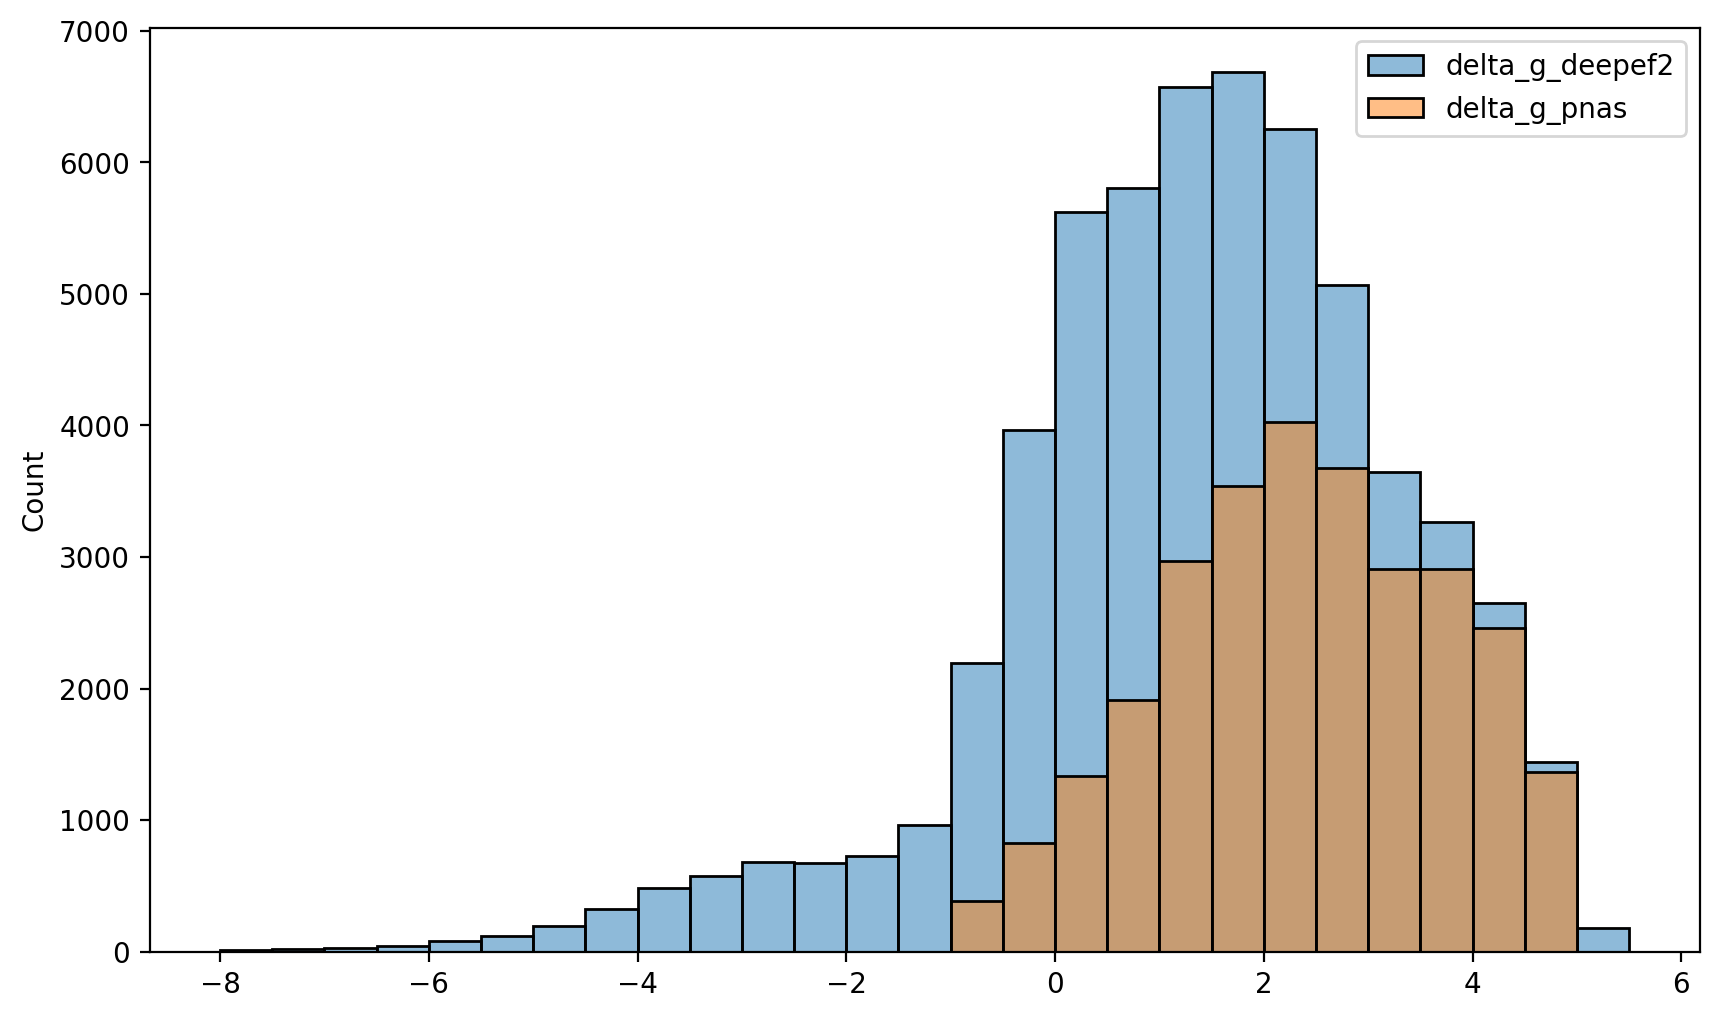

In [46]:
import matplotlib.pyplot as plt

# plot delta_g_pnas and delta_g_deepef tensors histogram
plt.figure(figsize=(10, 6))

sns.histplot(delta_g_deepef2.numpy(),bins=[i * 0.5 for i in range(-16, 12)], alpha=0.5, label='delta_g_deepef2')
sns.histplot(delta_g_pnas.numpy(), bins = [i * 0.5 for i in range(-16, 12)],alpha=0.5, label='delta_g_pnas')
plt.legend(loc='upper right')
plt.show()

# Check models test resultslts

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
pnas_df = pd.read_csv('../pnas_ds_model.csv')
deepef1_df = pd.read_csv('../deepef1_ds_model.csv')
deepef2_df = pd.read_csv('../deepef2_ds_model.csv')

In [13]:
pnas_df

,protein,deltaG,pred_deltaG
0,HHH_rd1_0142,3.605520,0.671113
1,HHH_rd1_0142,3.296825,0.671113
2,HHH_rd1_0142,3.213397,0.671113
3,HHH_rd1_0142,3.205563,0.671113
4,HHH_rd1_0142,3.328678,0.671113
...,...,...,...
28309,2K1B,1.761028,3.192597
28310,2K1B,1.917774,3.234856
28311,2K1B,1.957861,3.168217
28312,2K1B,1.417505,2.485541


In [20]:
def print_stats(df):
    "Correlation"
    print("Over all mutations:")
    print('Correlation:', df['deltaG'].corr(df['pred_deltaG']))
    # Group by protein name
    group_df = df.groupby('protein')
    corrs = []
    for name, group in group_df:
        corr = group['deltaG'].corr(group['pred_deltaG'])
        corrs.append(corr)
    print("Per protein:")
    print('Mean correlation:', np.mean(corrs))
    print('Median correlation:', np.median(corrs))
print('PNAS')
print_stats(pnas_df)
print('Deepef1')
print_stats(deepef1_df)
print('Deepef2')
print_stats(deepef2_df)

PNAS
Over all mutations:
Correlation: 0.4282738760608738
Per protein:
Mean correlation: 0.7106478702051298
Median correlation: 0.7735530311949668
Deepef1
Over all mutations:
Correlation: 0.5053745757406809
Per protein:
Mean correlation: 0.7206227531436522
Median correlation: 0.7723324357954885
Deepef2
Over all mutations:
Correlation: 0.5819165873553137
Per protein:
Mean correlation: 0.7214044312096446
Median correlation: 0.7737982221160546
